2. Implement a SIFT key point detector from scratch in python. For an image, (any image), compare your implementation with openCV implementation (with same parameters). If your code is not 95%-105% as efficient (compare run times) and not >75% accurate (precision/recall) as opencv, you will get a zero on this question. UNLESS you can find the exact reasons -- meaning pinpoint exact reasons -- for it not being as good as opencv. For example you can prove that opencv convolution is faster than your/numpy convolution (this is not true; its just and example of pinpoint reason). (25 pts) Use Shrek images to test above out.  
Stick to the key point detector algorithm for now, not the feature description part. 

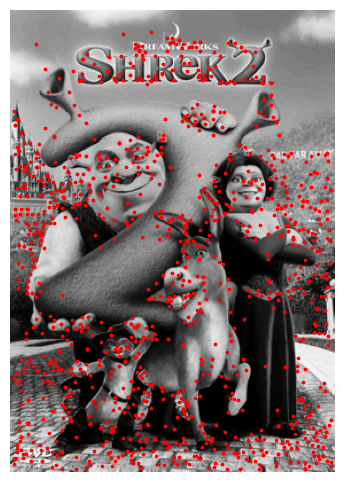

Time taken: 0.03427910804748535


In [21]:
import cv2
import matplotlib.pyplot as plt
import time

shreklarge = cv2.imread('reference.png')
gray_shreklarge = cv2.cvtColor(shreklarge,cv2.COLOR_BGR2GRAY)
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create()
keypoints1 = sift.detect(gray_shreklarge, None)
opencvtime1 = time.time() - start

# Plot the keypoints as red dots using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(gray_shreklarge, cmap='gray')

# Extract x and y coordinates of the keypoints and plot them as red points
for kp in keypoints1:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)  # kp.pt gives (x, y)

plt.axis('off')
# save the plot
plt.savefig('shreklarge_keypoints.png', bbox_inches='tight')
plt.show()

print("Time taken:",opencvtime1)

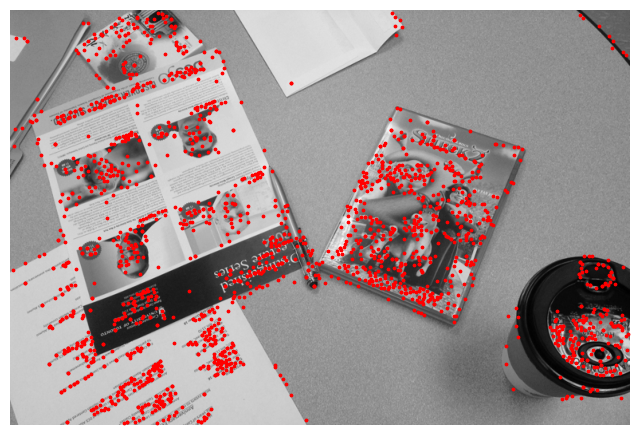

Time taken: 0.0443110466003418


In [2]:
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create()
keypoints2 = sift.detect(gray_shreksmall, None)
opencvtime2 = time.time() - start

# Plot the keypoints as red dots using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(gray_shreksmall, cmap='gray')

# Extract x and y coordinates of the keypoints and plot them as red points
for kp in keypoints2:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)  # kp.pt gives (x, y)

plt.axis('off')
plt.savefig('shreksmall_keypoints.png', bbox_inches='tight')
plt.show()

print("Time taken:",opencvtime2)

SIFT Detector Implementation in Python

Algorithm:

1. Generate base image for the gaussian kernel image pyramid.

2. Generate the gaussian kernels for each layer of the image pyramid.

3. Produce blurred and downsampled images for the gaussian kernel image pyramid.

4. Get the difference of gaussians from the layers of the image pyramid in (3) to get approximations of the laplacian convolution of the image at different sigma values.

5. Use the obtained DoG image pyramid to compute the keypoints by finding local maxima among the different layers of the for a neighbourhood of pixels.

6. Clean up the keypoints by removing duplicates and convert them back to the input image size.

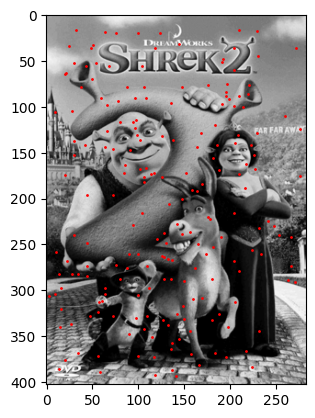

Time taken: 0.10834503173828125
Number of keypoints: 203


In [30]:
import numpy as np
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt

class SIFT_Keypoint_Detector:
    def __init__(self, nfeatures=0, nLayersinOctave=3, contrastThreshold=0.04, 
                 edgeThreshold=10, sigma=1.6):
        self.nfeatures = nfeatures
        self.nLayersinOctave = nLayersinOctave
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma
        self.SIFT_FIXPT_SCALE = 1

    def create_initial_image(self, img, double_image_size=False):
        if len(img.shape) == 3:
            gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            gray = img
        gray_float = gray.astype(np.float32) * self.SIFT_FIXPT_SCALE
        sig_diff = np.sqrt(max(self.sigma**2 - (1.6**2 * 4), 0.01))
        
        if double_image_size:
            gray_float = np.repeat(np.repeat(gray_float, 2, axis=0), 2, axis=1)
        
        return gaussian_filter(gray_float, sig_diff)

    def build_Gaussian_Pyramid(self, base, nOctaves):
        sigma = [self.sigma]
        k = 2**(1. / self.nLayersinOctave)
        for i in range(1, self.nLayersinOctave + 3):
            sigma_prev = k**(i - 1) * self.sigma
            sigma_total = sigma_prev * k
            sigma.append(np.sqrt(sigma_total**2 - sigma_prev**2))

        pyramid = []
        for o in range(nOctaves):
            octave = []
            # + 3 as we need nLayersinOctave + 2 DoG so that every image can be compared with one sigma above and below and +1, so need nLayersinOctave + 3 images in each octave to get these nLayersinOctave + 2 DoG images for each octave
            for i in range(self.nLayersinOctave + 3):
                if o == 0 and i == 0:
                    octave.append(base)
                elif i == 0:
                    # Downsample the last image from the previous octave
                    # base = octave[-1][::2, ::2]
                    # octave.append(base)
                    prev_octave_last = pyramid[(o - 1) * (self.nLayersinOctave + 3) + self.nLayersinOctave]
                    # downsample the image to half width and height by taking every second pixel
                    base = prev_octave_last[::2, ::2]  
                    octave.append(base)
                else:
                    # Apply Gaussian blur
                    src = octave[-1]
                    dst = gaussian_filter(src, sigma[i])
                    octave.append(dst)
            pyramid.extend(octave)
        return pyramid

    def build_DoG_Pyramid(self, Gaussian_Pyramid, nOctaves):
        dogpyr = []
        for o in range(nOctaves):
            octave = []
            for i in range(1, self.nLayersinOctave + 3):
                idx = o * (self.nLayersinOctave + 3) + i
                dog = Gaussian_Pyramid[idx] - Gaussian_Pyramid[idx - 1]
                octave.append(dog)
            dogpyr.extend(octave)
        return dogpyr

    def find_scale_space_extrema(self, DoG_pyramid):
        threshold = int(0.5 * self.contrastThreshold / self.nLayersinOctave * 255 * self.SIFT_FIXPT_SCALE)
        keypoints = []

        for o in range(len(DoG_pyramid) // (self.nLayersinOctave + 2)):
            for i in range(1, self.nLayersinOctave + 1):
                idx = o * (self.nLayersinOctave + 2) + i
                img = DoG_pyramid[idx]
                prev = DoG_pyramid[idx - 1]
                next = DoG_pyramid[idx + 1]

                window_view = np.lib.stride_tricks.sliding_window_view(img, (3, 3))
                center = window_view[:, :, 1, 1]
                neighbors = np.dstack([
                    window_view[:, :, 0, 0], window_view[:, :, 0, 1], window_view[:, :, 0, 2],
                    window_view[:, :, 1, 0], window_view[:, :, 1, 2],
                    window_view[:, :, 2, 0], window_view[:, :, 2, 1], window_view[:, :, 2, 2]
                ])

                prev_window = np.lib.stride_tricks.sliding_window_view(prev, (3, 3))
                next_window = np.lib.stride_tricks.sliding_window_view(next, (3, 3))

                is_max = (np.abs(center) > threshold) & (center > 0) & \
                         (center > neighbors.max(axis=2)) & \
                         (center > prev_window.max(axis=(2, 3))) & \
                         (center > next_window.max(axis=(2, 3)))

                is_min = (np.abs(center) > threshold) & (center < 0) & \
                         (center < neighbors.min(axis=2)) & \
                         (center < prev_window.min(axis=(2, 3))) & \
                         (center < next_window.min(axis=(2, 3)))

                extrema = np.logical_or(is_max, is_min)
                y, x = np.where(extrema)
                keypoints.extend([(o, i, r+1, c+1) for r, c in zip(y, x)])

        return keypoints

    def detect_keypoints(self, img):
        base = self.create_initial_image(img)
        nOctaves = int(round(np.log(min(base.shape)) / np.log(2) - 2))
        gpyr = self.build_Gaussian_Pyramid(base, nOctaves)
        dogpyr = self.build_DoG_Pyramid(gpyr, nOctaves)
        keypoints = self.find_scale_space_extrema(dogpyr)
        
        if self.nfeatures > 0 and len(keypoints) > self.nfeatures:
            keypoints = keypoints[:self.nfeatures]
        
        return keypoints

    def draw_keypoints(self,gray_img, keypoints, markersize=1):
        plt.imshow(gray_img, cmap='gray')
        height, width = gray_img.shape[:2]
        for (o, i, y, x) in keypoints:
            # scale the keypoint coordinates back to the input image scale
            scale = 2**o
            y_scaled = y * scale
            x_scaled = x * scale
            plt.plot(x_scaled, y_scaled, 'ro', markersize=markersize)
        plt.show()

start = time.time()
sift_detector = SIFT_Keypoint_Detector()
keypoints = sift_detector.detect_keypoints(gray_shreklarge)
scratch_impl_time = time.time() - start
# we have the keypoints as tuples (octave,layer_in_octave,y,x) now, but they are different scales of the image(downsampling after each octave). So we need to scale them back w.r.t. the original image using their octave value
sift_detector.draw_keypoints(gray_shreklarge, keypoints)
orgimg = cv2.imread('shreklarge_keypoints.png')
print("Time taken:",scratch_impl_time)
print("Number of keypoints:",len(keypoints))

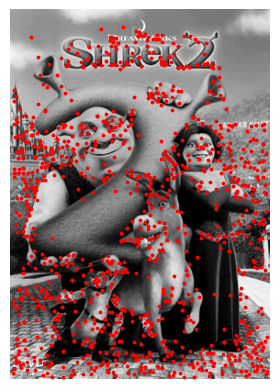

Time taken: 0.0245058536529541
Number of keypoints: 1158


In [23]:
import cv2
import matplotlib.pyplot as plt
import time

shreklarge = cv2.imread('reference.png')
gray_shreklarge = cv2.cvtColor(shreklarge,cv2.COLOR_BGR2GRAY)
shreksmall = cv2.imread('test.png')
gray_shreksmall = cv2.cvtColor(shreksmall,cv2.COLOR_BGR2GRAY)

start = time.time()
sift = cv2.SIFT_create(
    nfeatures=0,
    nOctaveLayers=3,  
    contrastThreshold=0.04,
    edgeThreshold=10,
    sigma=1.6)
keypoints1 = sift.detect(gray_shreklarge, None)
opencvtime1 = time.time() - start

# Plot the keypoints as red dots using matplotlib
plt.imshow(gray_shreklarge, cmap='gray')

# Extract x and y coordinates of the keypoints and plot them as red points
for kp in keypoints1:
    plt.scatter(kp.pt[0], kp.pt[1], c='red', s=3)  # kp.pt gives (x, y)

plt.axis('off')
# save the plot
plt.savefig('shreklarge_keypoints.png', bbox_inches='tight')
plt.show()

print("Time taken:",opencvtime1)
print("Number of keypoints:",len(keypoints1))